<a href="https://colab.research.google.com/github/Slautin/2024_Noise_BO/blob/main/1_Noise_BO_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Measurements with Noise: Bayesian Optimization for Co-optimized Noise and Property Discovery in Automated Experiments

**Notebook 1**: Double optimization acquisition approach. Simulation mode.

09/23/2024

* Author `Boris Slautin`
* Supervision `Sergei Kalinin`
* GPAX library `Maxim Ziatdinov`


In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm

from typing import Union, Dict, Callable, Optional, Type, Tuple

import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal


import jaxlib
import jax.numpy as jnp

import gpax
from gpax.utils import get_keys

import imageio
from IPython.core.display import Video
from sklearn.linear_model import LinearRegression

import h5py

gpax.utils.enable_x64()

In [3]:
#@title functions: f(x) and Noise model
np.random.seed(1)

# Define the Forrester function
def forrester_function(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)

def forester_function2D(x, t):
  return forrester_function(x)

def variable_noise(t, a, b,):
  return a/np.sqrt(t)+b

def variable_noise2D(x, t, a, b,):
  return variable_noise(t, a, b)

def variable_noise2D_linearized(x, sqrt_t, a, b,):
  return a*sqrt_t + b


#reward for Noise model
def reward2(T, N, tt=0.1, nn=2):
  '''
  Square-linear reward function
  '''
  _rew = - tt*T**2 - nn*N
  return (_rew.min(), np.ptp(_rew)), (_rew - _rew.min())/np.ptp(_rew)

def reward2_unc(N_uncertainty, nn=2):
  return abs(nn)*N_uncertainty

In [4]:
#@title auxiliary functions: saving

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)

    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

def make_video(path, fig_list, fps=1):
  llist = []
  for f in fig_list:
    f.canvas.draw()
    rgb_array = np.frombuffer(f.canvas.tostring_rgb(), dtype=np.uint8)
    rgb_array = rgb_array.reshape(f.canvas.get_width_height()[::-1] + (3,))
    llist.append(rgb_array)

    imageio.mimwrite(path, llist , fps = fps)

# Rewards for noise

In [5]:
a = np.linspace(1, 15, 10)
b = np.linspace(0, 10, 10)

# Set up colormaps
cmap_a = plt.get_cmap('jet')  # Colormap for 'a'
norm_a = Normalize(vmin=np.min(a), vmax=np.max(a))

cmap_b = plt.get_cmap('jet')   # Colormap for 'b'
norm_b = Normalize(vmin=np.min(b), vmax=np.max(b))

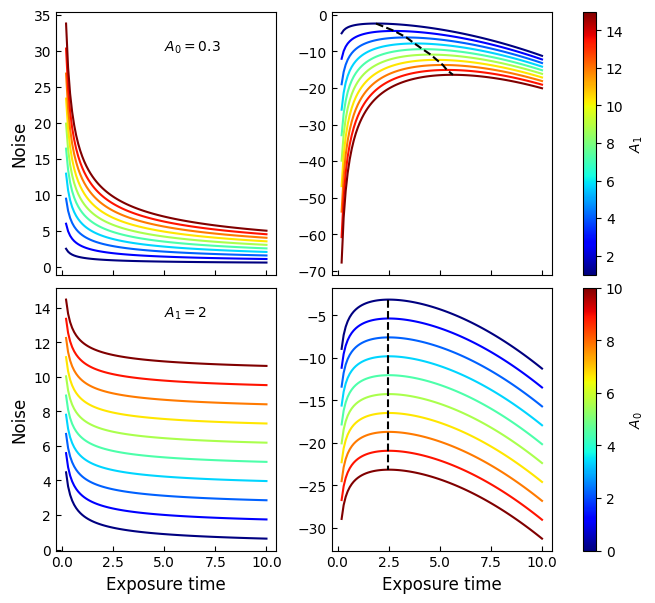

In [6]:
t_all = np.linspace(0.2, 10, 100)

fig, ax = plt.subplots(2, 2, figsize=(8,7), sharex=True)
fig.subplots_adjust(wspace=.25, hspace=.05)

rew_max = np.array([])
t_rew_max = np.array([])

for aa in a:
  color = cmap_a(norm_a(aa))
  _noise = variable_noise(t_all, aa, 0.3)
  noise_all = np.linspace(0, np.max(_noise),100)
  coef, _reward = reward2(t_all, _noise)

  ax[0,0].plot(t_all, _noise, c=color)
  ax[0,1].plot(t_all, _reward*coef[1]+ coef[0], c=color)

  rew_max = np.append(rew_max, np.max(_reward)*coef[1]+coef[0])
  t_rew_max = np.append(t_rew_max, t_all[np.argmax(_reward).astype(int)])

ax[0,1].plot(t_rew_max, rew_max,'--', color='black')

rew_max = np.array([])
t_rew_max = np.array([])

for bb in b:
  color = cmap_b(norm_b(bb))
  _noise = variable_noise(t_all, 2, bb)
  noise_all = np.linspace(0, np.max(_noise),100)
  coef, _reward = reward2(t_all, _noise)

  ax[1,0].plot(t_all, _noise, c=color)
  ax[1,1].plot(t_all, _reward*coef[1]+coef[0],c=color)

  rew_max = np.append(rew_max, np.max(_reward)*coef[1]+coef[0])
  t_rew_max = np.append(t_rew_max, t_all[np.argmax(_reward).astype(int)])

ax[1,1].plot(t_rew_max, rew_max,'--', color='black')

sm_a = plt.cm.ScalarMappable(cmap=cmap_a, norm=norm_a)
sm_a.set_array([])
cbar_a = fig.colorbar(sm_a, ax=ax[0], location='right', label='$A_1$')

sm_b = plt.cm.ScalarMappable(cmap=cmap_b, norm=norm_b)
sm_b.set_array([])
cbar_b = fig.colorbar(sm_b, ax=ax[1], location='right', label='$A_0$')

for _ in ax.flatten():
  _.tick_params('both', direction='in')

ax[0,0].set_ylabel('Noise', fontsize=12)
ax[1,0].set_ylabel('Noise', fontsize=12)
ax[1,0].set_xlabel('Exposure time', fontsize=12)
ax[1,1].set_xlabel('Exposure time', fontsize=12)

ax[0,0].text(5, 30, s='$A_0=0.3$', fontsize=10)
ax[1,0].text(5, 13.5, s='$A_1=2$', fontsize=10)

fig.savefig('noise_reward_vs_params.jpg', dpi=300, bbox_inches='tight')

In [7]:
x_all = np.linspace(0, 1, 100)
t_all = np.linspace(0.2, 10, 100)
noise_all = np.linspace(0, np.max(variable_noise(t_all, 2, 0.1)),100)
T, N = np.meshgrid(t_all, noise_all)
_, reward_ar = reward2(T, N)

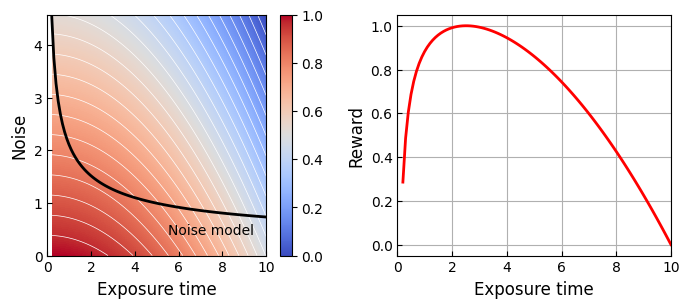

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
cax = ax[0].imshow(reward2(T, N)[1], extent=[T.min(), T.max(), N.min(), N.max()], origin='lower', aspect='auto', cmap='coolwarm')

# Add contour lines
contour = ax[0].contour(T, N, reward2(T, N)[1], levels=30, colors='white', linewidths=0.5)

ax[0].plot(t_all, variable_noise(t_all, 2, 0.1), color='black', lw=2)
ax[0].text(5.5, 0.4, s='Noise model', fontsize=10)
ax[0].set_ylabel('Noise', fontsize=12)

ax[1].plot(t_all, reward2(t_all, variable_noise(t_all, 2, 0.1))[1], color='red', lw=2)
ax[1].grid()

# Add colorbar for reference
cbar = fig.colorbar(cax, ax=ax[0], orientation='vertical')
ax[1].set_ylabel('Reward', fontsize=12)

fig.tight_layout()

for _ in ax:
  _.set_xlabel('Exposure time', fontsize=12)
  _.tick_params('both', direction='in')
  _.set_xlim(0, 10)

fig.savefig('reward_noise.jpg', dpi=300, bbox_inches='tight')

# Exact solution

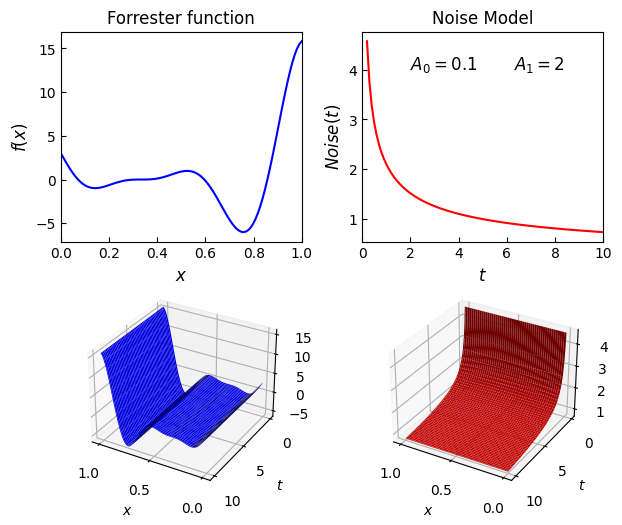

In [9]:
#ground truth image
a=2
b=0.1

x_all = np.linspace(0, 1, 100)
t_all = np.linspace(0.2, 10, 100)
X, T = np.meshgrid(x_all, t_all)
Y     = forester_function2D(X, T)
Noise = variable_noise2D(X, T, a, b)


fig, ax = plt.subplots(2, 2, figsize=(7,6))

ax[0,0].set_xlabel("$x$", fontsize=12)
ax[0,0].set_ylabel("$f(x)$", fontsize=12)
ax[0,0].plot(x_all, forrester_function(x_all), '-', color='blue')
ax[0,0].set_title('Forrester function')
ax[0,0].set_xlim(0,1)

ax[0,1].set_xlabel("$t$", fontsize=12)
ax[0,1].set_ylabel("$Noise(t)$", fontsize=12)
ax[0,1].plot(t_all, variable_noise(t_all, a, b), '-', color='red')
ax[0,1].set_title('Noise Model')
ax[0,1].set_xlim(0,10)
ax[0,1].text(2, 4, s=f'$A_0={b}$\t$A_1={a}$', fontsize=12)

ax[1,0].axis('off')
ax[1,1].axis('off')

ax3d_1 = fig.add_subplot(2, 2, 3, projection='3d')
ax3d_1.plot_surface(X, T, Y, color='blue')
ax3d_1.set_xlabel('$x$')
ax3d_1.set_ylabel('$t$')
ax3d_1.set_xticks([0,0.5,1])
ax3d_1.set_yticks([0,5,10])
ax3d_1.view_init(elev=30, azim=120)

ax3d_2 = fig.add_subplot(2, 2, 4, projection='3d')
ax3d_2.plot_surface(X, T, Noise, color='red')
ax3d_2.set_xlabel('$x$')
ax3d_2.set_ylabel('$t$')
ax3d_2.set_xticks([0,0.5,1])
ax3d_2.set_yticks([0,5,10])
ax3d_2.view_init(elev=30, azim=120)

for _ in ax.flatten():
  _.tick_params('both', direction='in')

fig.subplots_adjust(wspace=0.25)

fig.savefig('ground_truth.jpg', dpi=300, bbox_inches='tight')

In [10]:
#@title function: modified kernels
def square_scaled_distance(X: jnp.ndarray, Z: jnp.ndarray,
                           lengthscale: Union[jnp.ndarray, float] = 1.
                           ) -> jnp.ndarray:
    r"""
    Computes a square of scaled distance, :math:`\|\frac{X-Z}{l}\|^2`,
    between X and Z are vectors with :math:`n x num_features` dimensions
    """
    scaled_X = X / lengthscale
    scaled_Z = Z / lengthscale
    X2 = (scaled_X ** 2).sum(1, keepdims=True)
    Z2 = (scaled_Z ** 2).sum(1, keepdims=True)
    XZ = jnp.matmul(scaled_X, scaled_Z.T)
    r2 = X2 - 2 * XZ + Z2.T
    return r2.clip(0)

def add_jitter(x, jitter=1e-6):
    return x + jitter

def _sqrt(x, eps=1e-12):
    return jnp.sqrt(x + eps)


def MaternKernel_1dim(X: jnp.ndarray, Z: jnp.ndarray, params: Dict[str, jnp.ndarray], noise: int = 0, jitter: float = 1e-6, **kwargs) -> jnp.ndarray:
    r2 = square_scaled_distance(X[:,0:1], Z[:,0:1], params["k_length"])
    r = _sqrt(r2)
    sqrt5_r = 5**0.5 * r
    k = (1 + sqrt5_r + (5/3) * r2) * jnp.exp(-sqrt5_r)
    if X.shape == Z.shape:
        k += add_jitter(noise, jitter) * jnp.eye(X.shape[0])
    return k

def RBF_2nd_dim(X: jnp.ndarray, Z: jnp.ndarray, params: Dict[str, jnp.ndarray], noise: int = 0, jitter: float = 1e-6, **kwargs) -> jnp.ndarray:
    r2 = square_scaled_distance(X[:,1:2], Z[:,1:2], params["k_length"])
    k = params["k_scale"] * jnp.exp(-0.5 * r2)
    if X.shape == Z.shape:
        k += add_jitter(noise, jitter) * jnp.eye(X.shape[0])
    return k


#introducing custom Mettern-based kernel function
gpax.utils.set_kernel_fn(MaternKernel_1dim)
gpax.utils.set_kernel_fn(RBF_2nd_dim)

<PjitFunction of <function RBF_2nd_dim at 0x7f2fd7ee5c60>>

In [11]:
#@title viMeasuredNoiseGP
kernel_fn_type = Callable[[jnp.ndarray, jnp.ndarray, Dict[str, jnp.ndarray], jnp.ndarray], jnp.ndarray]

class viMeasuredNoiseGP(gpax.ExactGP):
  def __init__(self,
               input_dim: int,
               kernel: Union[str, kernel_fn_type],
               mean_fn: Optional[Callable[[jnp.ndarray, Dict[str, jnp.ndarray]], jnp.ndarray]] = None,
               kernel_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
               mean_fn_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
               lengthscale_prior_dist: Optional[dist.Distribution] = None,
               mean_fn_noise: Optional[Callable[[jnp.ndarray, Dict[str, jnp.ndarray]], jnp.ndarray]] = None,
               mean_fn_prior_noise: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
               guide: str = 'delta'
               ) -> None:
        args = (input_dim, kernel, mean_fn, kernel_prior, mean_fn_prior, None, None, lengthscale_prior_dist)
        super(viMeasuredNoiseGP, self).__init__(*args)
        self.measured_noise = None
        self.noise_predicted = None
        self.X_train = None
        self.y_train = None
        self.guide_type = AutoNormal if guide == 'normal' else AutoDelta
        self.svi = None

        self.mean_fn_noise = mean_fn_noise
        self.mean_fn_prior_noise = mean_fn_prior_noise

  def model(self, X: jnp.ndarray, y: jnp.ndarray = None, measured_noise: jnp.ndarray = None, **kwargs) -> None:
        """GP model that accepts measured noise"""
        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])
        # Sample kernel parameters
        if self.kernel_prior:
            kernel_params = self.kernel_prior()
        else:
            kernel_params = self._sample_kernel_params()
        # Since we provide a measured noise, we don't infer it
        noise = numpyro.deterministic("noise", jnp.array(0.0))
        # Add mean function (if any)
        if self.mean_fn is not None:
            args = [X]
            if self.mean_fn_prior is not None:
                args += [self.mean_fn_prior()]
            f_loc += self.mean_fn(*args).squeeze()
        # compute kernel (with zero noise)
        k = self.kernel(X, X, kernel_params, 0, **kwargs)
        # Sample y according to the standard Gaussian process formula. Add measured noise to the covariance matrix
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k+jnp.diag(measured_noise)),
            obs=y,
        )

  def fit(self,
          rng_key: jnp.array,
          X: jnp.ndarray,
          y: jnp.ndarray,
          measured_noise: jnp.ndarray,
          num_steps: int = 1000,
          step_size: float = 5e-3,
          progress_bar: bool = True,
          print_summary: bool = True,
          device: Type[jaxlib.xla_extension.Device] = None,
          **kwargs: float
          ) -> None:

        X, y = self._set_data(X, y)
        if device:
            X = jax.device_put(X, device)
            y = jax.device_put(y, device)
        self.X_train = X
        self.y_train = y
        self.measured_noise = measured_noise

        optim = numpyro.optim.Adam(step_size=step_size, b1=0.5)
        self.svi = SVI(
            self.model,
            guide=self.guide_type(self.model),
            optim=optim,
            loss=Trace_ELBO(),
            **kwargs
        )

        self.kernel_params = self.svi.run(
            rng_key, num_steps, X, y, measured_noise, progress_bar=progress_bar)[0]

        if print_summary:
            self._print_summary()

  def get_samples(self) -> Dict[str, jnp.ndarray]:
        return self.svi.guide.median(self.kernel_params)

  def _print_summary(self) -> None:
        params_map = self.get_samples()
        print('\nInferred GP parameters')
        for (k, vals) in params_map.items():
            spaces = " " * (15 - len(k))
            print(k, spaces, jnp.around(vals, 4))

  def predict(self,
              rng_key: jnp.ndarray,
              X_new: jnp.ndarray,
              samples: Optional[Dict[str, jnp.ndarray]] = None,
              noiseless: bool = False,
              device: Type[jaxlib.xla_extension.Device] = None,
              noise_prediction_method: str = 'gpreg',
              noise_prediction_kernel = 'RBF',
              **kwargs: float
              ) -> Tuple[jnp.ndarray, jnp.ndarray]:

        if noise_prediction_method not in ["linreg", "gpreg"]:
          raise NotImplementedError(
              "For noise prediction method, select between 'linreg' and 'gpreg'")

        noise_pred_fn = self.linreg if noise_prediction_method == "linreg" else self.gpreg
        X_new = self._set_data(X_new)

        def sigma_sample(rng_key, K, X_new_shape):
            sig = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0))
            return sig * jra.normal(rng_key, X_new_shape[:1])

        if self.noise_predicted is not None:
            noise_predicted = self.noise_predicted
        else:
            print('----Noise model calculation----')
            noise_model, kp, noise_predicted = noise_pred_fn(self.X_train,
                                                             self.measured_noise,
                                                              X_new,
                                                              kernel = noise_prediction_kernel,
                                                              **kwargs)
            self.noise = noise_predicted
            self.noise_kernel_params = kp
            self.noise_model = noise_model
        if samples is None:
            samples = self.get_samples()
            samples['noise'] = jnp.array([0])
            self.samples = samples
        if device:
            self._set_training_data(device=device)
            X_new = jax.device_put(X_new, device)
            samples = jax.device_put(samples, device)


        mean, K = self.get_mvn_posterior(X_new, samples, noiseless, **kwargs)
        K += jnp.diag(noise_predicted.flatten())

        return mean, K.diagonal()

  def gpreg(self, x, y, x_new, kernel='RBF', **kwargs):
        keys = get_keys()
        vigp = gpax.viGP(self.kernel_dim,
                         kernel = kernel,
                         mean_fn= self.mean_fn_noise,
                         mean_fn_prior= self.mean_fn_prior_noise,
                         **kwargs)
        x_lin = x.copy()
        x_new_lin = x_new.copy()
        x_lin[:,1] =  1/np.sqrt(x[:,1])
        x_new_lin[:,1] = 1/np.sqrt(x_new[:,1])

        vigp.fit(keys[0], x_lin, y, num_steps=10000,  progress_bar=True, print_summary=True, noiseless=True, **kwargs)#step_size=1e-5,

        mmean, unc = vigp.predict(keys[1], x_new_lin, noiseless=False)
        self.noise_unc = unc


        return vigp, vigp.get_samples(), mmean

  def linreg(self, x, y, x_new, kernel=None, **kwargs):
        #parameter kernel is unfunctional
        x_lin = 1/np.sqrt(x[:,1])
        x_new_lin = 1/np.sqrt(x_new[:,1])

        lreg = LinearRegression()
        lreg.fit(x_lin.reshape(-1, 1), y.reshape(-1, 1), **kwargs)
        mmean = lreg.predict(x_new_lin.reshape(-1, 1))
        samples = {'a': lreg.coef_[0][0], 'b': lreg.intercept_[0]}
        return lreg, samples, mmean


In [12]:
#@title double-optimization acquisition function


def join_acq(base_acq: str,
             noise_function,
             noise_reward_function,
             rng_key: jnp.ndarray, model: Type[gpax.ExactGP],
             X: jnp.ndarray, beta: float = .25,
             maximize: bool = False, n: int = 1,
             noiseless: bool = False,
             penalty: Optional[str] = None,
             recent_points: jnp.ndarray = None,
             grid_indices: jnp.ndarray = None,
             penalty_factor: float = 1.0,
             **kwargs) -> jnp.ndarray:
  if base_acq == 'UE':
    acq_f = gpax.acquisition.UE
  elif base_acq == 'UCB':
    acq_f = gpax.acquisition.UCB
  elif base_acq == 'EI':
    acq_f = gpax.acquisition.EI
  elif base_acq == 'PI':
    acq_f = gpax.acquisition.PI
  else:
    raise NotImplementedError(f'Acquisition function {base_acq} not implemented')

  # if you place acq_funct for noise after the acq for x, you need to recalculate predictions
  if len(model.noise) == len(X):
    f, u = model.noise, model.noise_unc
  else:
    X_lin = X.copy()
    X_lin[:,1] = 1/np.sqrt(X_lin[:,1])
    f, u = model.noise_model.predict(rng_key, X_lin, noiseless=True)

  r = noise_reward_function(X[:,1], f)
  r_u = reward2_unc(u)
  moments = (r, r_u)
  acq_noise = gpax.acquisition.base_acq.ei(moments, maximize=True)
  acq_noise_norm = (acq_noise - acq_noise.min())/acq_noise.ptp()

  #---- acq_function for compositional axis
  #all durations
  _t = np.unique(X[:,1])
  #composition profile min duration
  _x0 = X[X[:,1] == _t[0]]
  #recent points
  _r_points = recent_points.copy()
  _r_points[:,1] = _t[0]

  acq = acq_f(rng_key, model, _x0, recent_points = _r_points)
  acq_norm = (acq - acq.min())/acq.ptp()

  #---join acqisition function
  acq_final = np.array(acq_noise_norm.copy())#_reward.copy()
  for tt in _t:
    acq_final[X[:,1] == tt] += acq_norm

  return acq_final/2

In [13]:
  #@title structured GP priors

  def mean_func_noise(coord: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return variable_noise2D(coord[:,0], coord[:,1], params['a'], params['b'],)

  def prior_noise():
    # Sample model parameters
    a = numpyro.sample("a", numpyro.distributions.Uniform(0,15))
    b = numpyro.sample("b", numpyro.distributions.Uniform(0,15))
    # Return sampled parameters as a dictionary
    return {'a': a, 'b': b}

  def mean_func_noise_linearized(coord: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return variable_noise2D_linearized(coord[:,0], coord[:,1], params['a'], params['b'],)


In [14]:
#@title auxiliary functions: plotting results


def plot_3d(func, var, points=None):
  if len(func.shape) == 1:
    s = int(np.sqrt(len(func)))
    func = func.reshape(s,s)
    var = var.reshape(s,s)

  # Plot the surface
  fig = plt.figure(figsize=(7, 3))
  ax1 = fig.add_subplot(121, projection='3d')
  ax1.plot_surface(X, T, func, alpha=0.7)

  # Set labels
  ax1.set_xlabel('$x$')
  ax1.set_ylabel('$t$')
  ax1.view_init(elev=30, azim=120)
  ax1.set_title('Function')

  if isinstance(points, np.ndarray):
    ax1.scatter(*points, color='red')


  ax2 = fig.add_subplot(122, projection='3d')
  ax2.plot_surface(X, T, var, alpha=0.7)

  # Set labels
  ax2.set_xlabel('x')
  ax2.set_ylabel('t')
  ax2.view_init(elev=30, azim=120)
  ax2.set_title('Uncertainty')

  # Show plot
  return fig

Optimal measurement duration for a = 2 and b = 0.1: 2.48

------------------  Ground truth -------------------



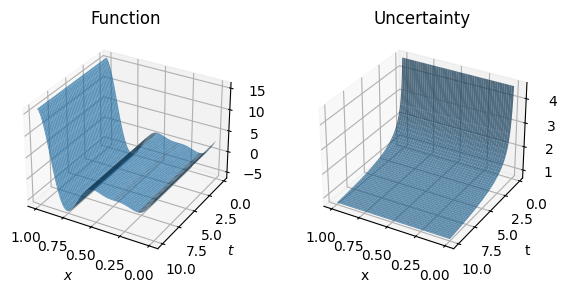


------------------ Iteration 0 -------------------



100%|██████████| 10000/10000 [00:11<00:00, 843.70it/s, init loss: 39.5392, avg. loss [9501-10000]: 30.8378]



Inferred GP parameters
k_length         [0.6023 0.5785]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:07<00:00, 1326.32it/s, init loss: 72.1786, avg. loss [9501-10000]: 9.1768]



Inferred GP parameters
k_length         [0.3608 0.3608]
k_scale          0.2041
noise            0.2049
a                1.9478000000000002
b                0.0198

------------------  Results -------------------



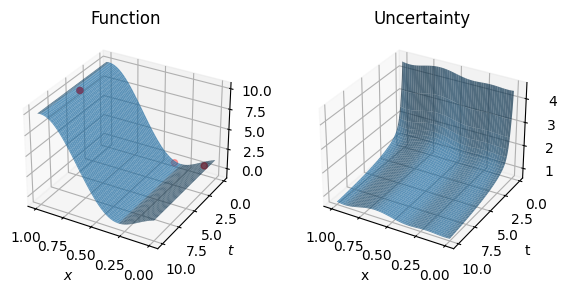

(a, b) =  (1.948, 0.02)
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2302.08it/s, init loss: 69.4960, avg. loss [9501-10000]: 9.1873]



Inferred GP parameters
k_length         [0.3631 0.3485]
k_scale          0.20420000000000002
noise            0.2064
a                1.9541000000000002
b                0.017
Next location (x, t) =  [0.64646465 2.08080808]


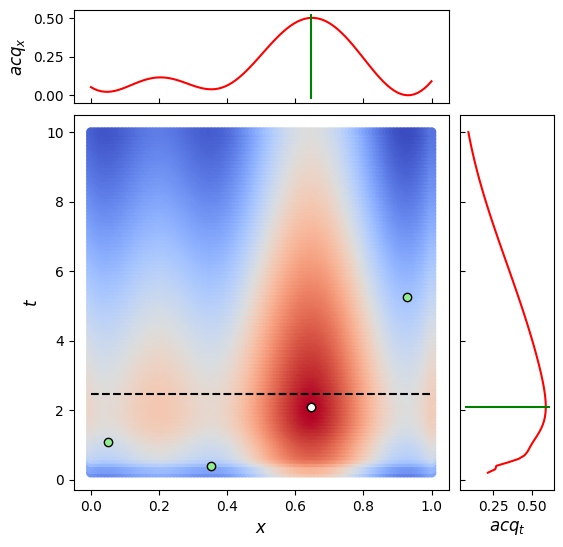

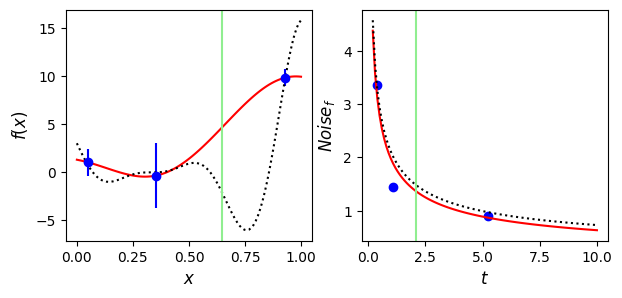


------------------ Iteration 1 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1707.08it/s, init loss: 43.1148, avg. loss [9501-10000]: 35.0690]



Inferred GP parameters
k_length         [0.7346 0.1428]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:03<00:00, 2930.27it/s, init loss: 74.3402, avg. loss [9501-10000]: 9.5277]



Inferred GP parameters
k_length         [0.3822 0.3822]
k_scale          0.1752
noise            0.16160000000000002
a                1.9629
b                0.020800000000000003

------------------  Results -------------------



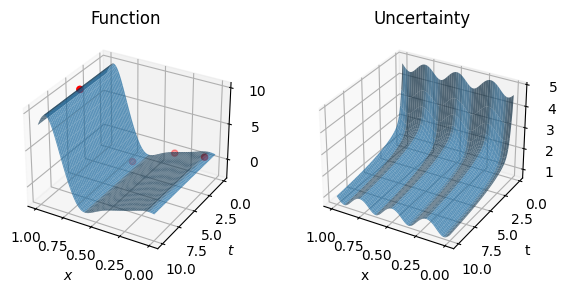

(a, b) =  (1.963, 0.021)
----Noise model calculation----


100%|██████████| 10000/10000 [00:03<00:00, 2811.27it/s, init loss: 71.2508, avg. loss [9501-10000]: 9.5608]



Inferred GP parameters
k_length         [0.3874 0.3624]
k_scale          0.1709
noise            0.1631
a                1.9649
b                0.0152
Next location (x, t) =  [0.2020202  2.17979798]


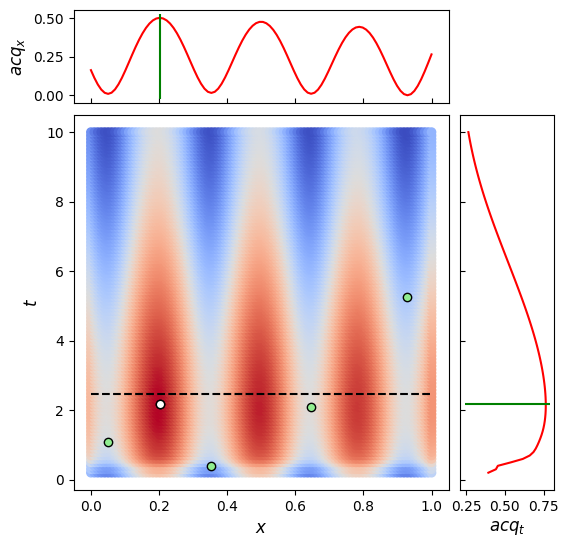

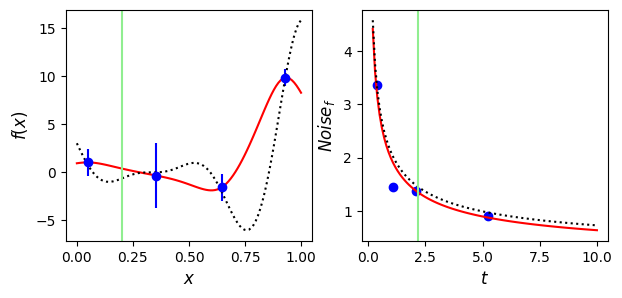


------------------ Iteration 2 -------------------



100%|██████████| 10000/10000 [00:04<00:00, 2127.69it/s, init loss: 44.5175, avg. loss [9501-10000]: 36.4829]



Inferred GP parameters
k_length         [0.7332 0.1435]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2055.41it/s, init loss: 75.8429, avg. loss [9501-10000]: 9.7486]



Inferred GP parameters
k_length         [0.3749 0.3749]
k_scale          0.1623
noise            0.1273
a                1.9737
b                0.023

------------------  Results -------------------



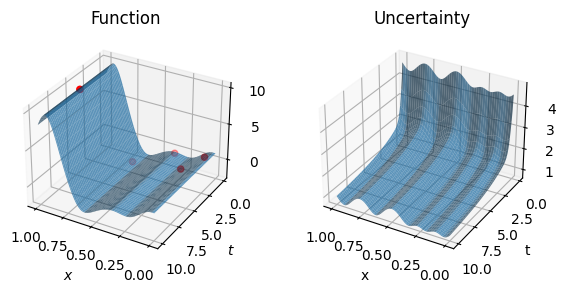

(a, b) =  (1.974, 0.023)
----Noise model calculation----


100%|██████████| 10000/10000 [00:03<00:00, 2603.46it/s, init loss: 72.4593, avg. loss [9501-10000]: 9.9544]



Inferred GP parameters
k_length         [0.4223 0.3396]
k_scale          0.1477
noise            0.1427
a                1.9768000000000001
b                0.0251
Next location (x, t) =  [0.50505051 1.88282828]


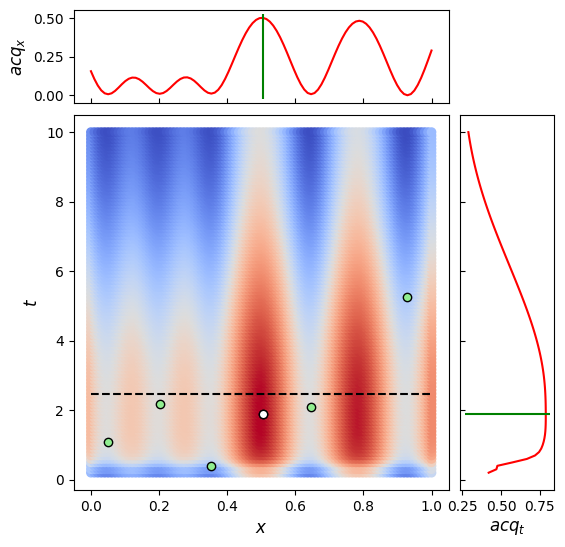

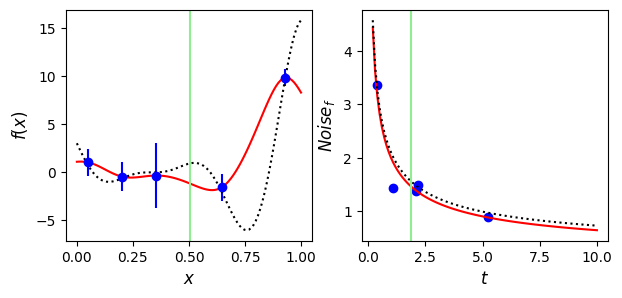


------------------ Iteration 3 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1671.66it/s, init loss: 46.4184, avg. loss [9501-10000]: 38.2917]



Inferred GP parameters
k_length         [0.7034 0.1455]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:03<00:00, 2688.08it/s, init loss: 77.1973, avg. loss [9501-10000]: 9.7446]



Inferred GP parameters
k_length         [0.3664 0.3664]
k_scale          0.154
noise            0.09580000000000001
a                1.9785000000000001
b                0.021400000000000002

------------------  Results -------------------



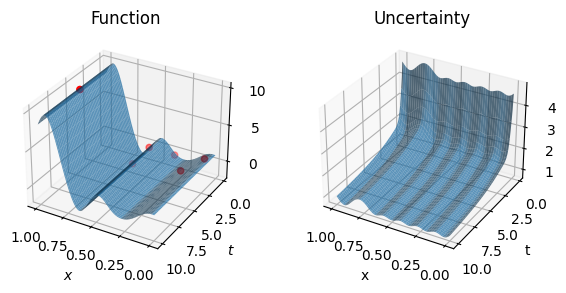

(a, b) =  (1.979, 0.021)
----Noise model calculation----


100%|██████████| 10000/10000 [00:03<00:00, 2658.70it/s, init loss: 73.6171, avg. loss [9501-10000]: 10.0198]



Inferred GP parameters
k_length         [0.4585 0.3261]
k_scale          0.1365
noise            0.1091
a                1.982
b                0.024
Next location (x, t) =  [0.78787879 1.18989899]


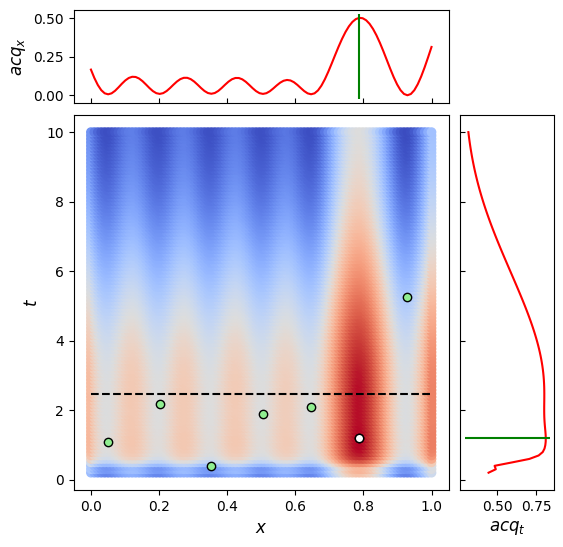

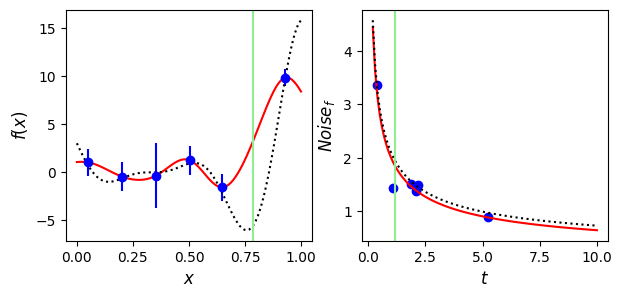


------------------ Iteration 4 -------------------



100%|██████████| 10000/10000 [00:04<00:00, 2005.77it/s, init loss: 61.4499, avg. loss [9501-10000]: 47.1038]



Inferred GP parameters
k_length         [0.9059 0.0577]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2028.01it/s, init loss: 78.4933, avg. loss [9501-10000]: 10.0839]



Inferred GP parameters
k_length         [0.4224 0.4224]
k_scale          0.1355
noise            0.10210000000000001
a                2.0194
b                0.0263

------------------  Results -------------------



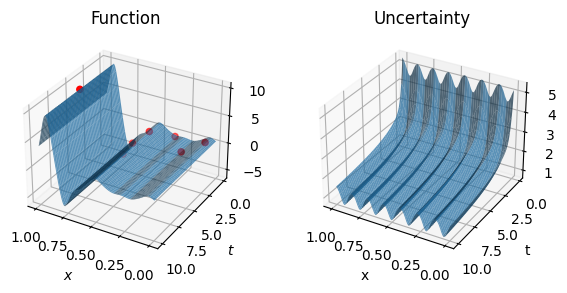

(a, b) =  (2.019, 0.026)
----Noise model calculation----


100%|██████████| 10000/10000 [00:03<00:00, 2539.61it/s, init loss: 75.5815, avg. loss [9501-10000]: 10.1376]



Inferred GP parameters
k_length         [0.4555 0.3759]
k_scale          0.12190000000000001
noise            0.0942
a                2.0124
b                0.0216
Next location (x, t) =  [1.         2.57575758]


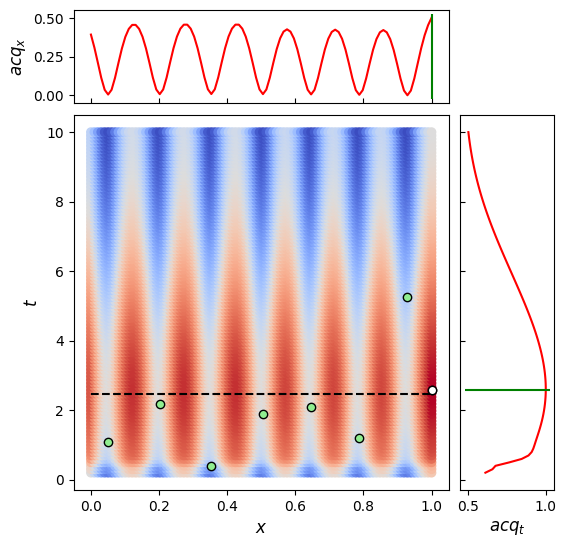

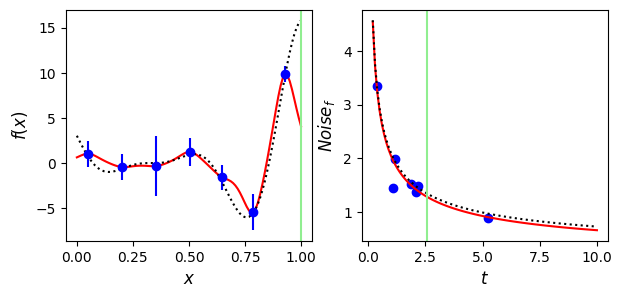


------------------ Iteration 5 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1522.98it/s, init loss: 100.8072, avg. loss [9501-10000]: 88.1140]



Inferred GP parameters
k_length         [1.0061 0.1084]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2169.67it/s, init loss: 79.6986, avg. loss [9501-10000]: 9.9411]



Inferred GP parameters
k_length         [0.4384 0.4384]
k_scale          0.12890000000000001
noise            0.08460000000000001
a                2.0235000000000003
b                0.022500000000000003

------------------  Results -------------------



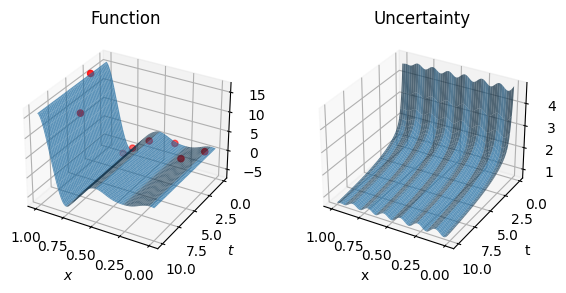

(a, b) =  (2.023, 0.023)
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1868.46it/s, init loss: 77.3434, avg. loss [9501-10000]: 10.0561]



Inferred GP parameters
k_length         [0.474  0.3819]
k_scale          0.11270000000000001
noise            0.0771
a                2.012
b                0.0175
Next location (x, t) =  [0.         2.57575758]


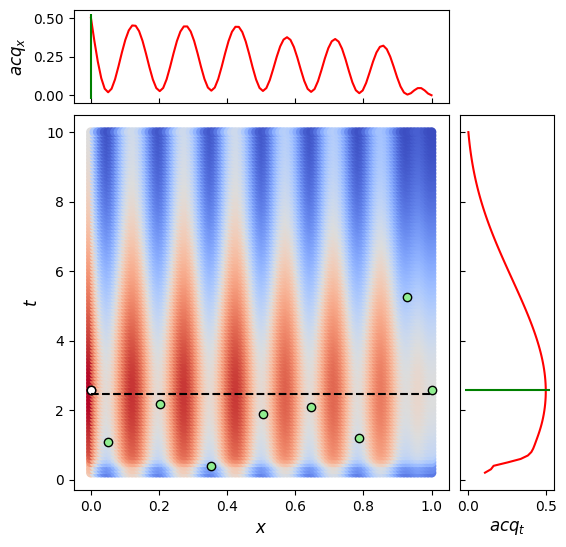

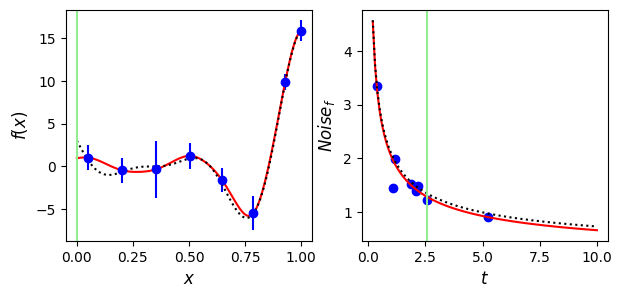


------------------ Iteration 6 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1669.37it/s, init loss: 103.9066, avg. loss [9501-10000]: 91.1122]



Inferred GP parameters
k_length         [1.0073 0.1082]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2308.48it/s, init loss: 80.7814, avg. loss [9501-10000]: 9.6717]



Inferred GP parameters
k_length         [0.4438 0.4438]
k_scale          0.12440000000000001
noise            0.0703
a                2.0263
b                0.0211

------------------  Results -------------------



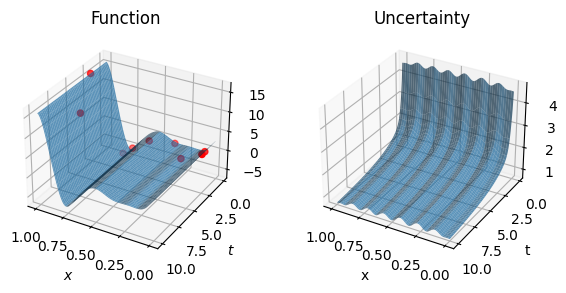

(a, b) =  (2.026, 0.021)
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2277.68it/s, init loss: 78.5609, avg. loss [9501-10000]: 9.9362]



Inferred GP parameters
k_length         [0.5004 0.3425]
k_scale          0.10260000000000001
noise            0.0632
a                2.012
b                0.022000000000000002
Next location (x, t) =  [0.42424242 2.47676768]


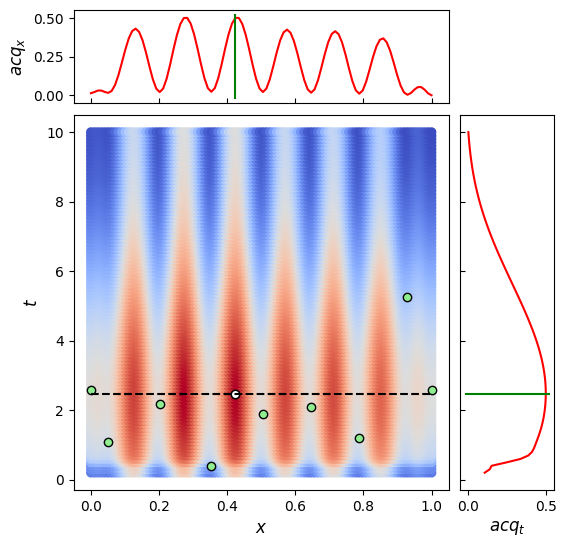

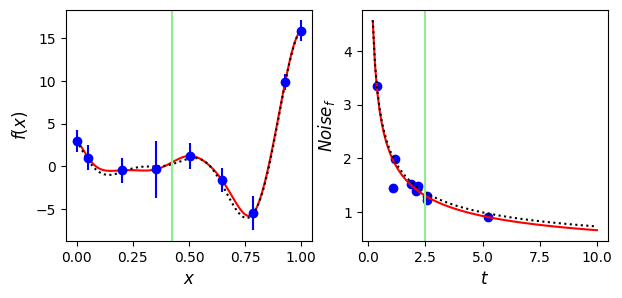


------------------ Iteration 7 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1827.24it/s, init loss: 103.6169, avg. loss [9501-10000]: 90.7889]



Inferred GP parameters
k_length         [1.0081 0.1084]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1898.59it/s, init loss: 63.8681, avg. loss [9501-10000]: 8.9058]



Inferred GP parameters
k_length         [0.4875 0.4875]
k_scale          0.14880000000000002
noise            0.0591
a                1.4607
b                0.2983

------------------  Results -------------------



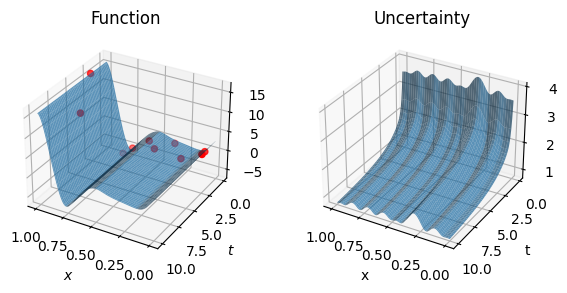

(a, b) =  (1.461, 0.298)
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2176.09it/s, init loss: 67.4453, avg. loss [9501-10000]: 9.1135]



Inferred GP parameters
k_length         [0.5406 0.4175]
k_scale          0.1173
noise            0.0495
a                1.4438
b                0.3346
Next location (x, t) =  [0.31313131 0.4969697 ]


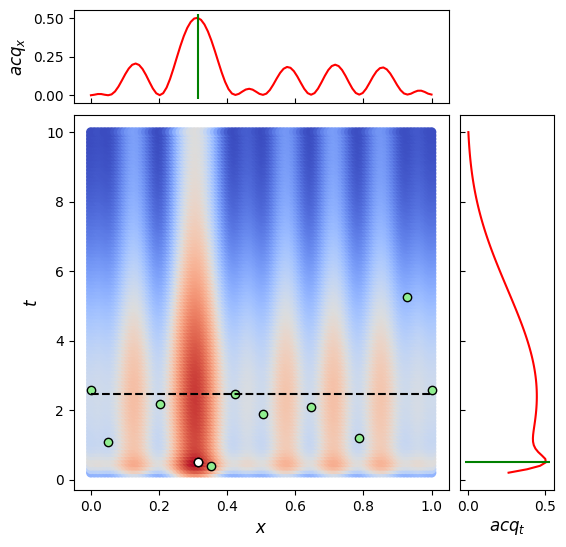

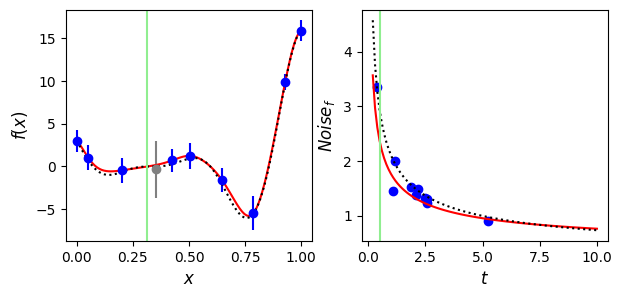


------------------ Iteration 8 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1763.22it/s, init loss: 105.0847, avg. loss [9501-10000]: 92.3252]



Inferred GP parameters
k_length         [1.0081 0.1087]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:06<00:00, 1560.21it/s, init loss: 78.3267, avg. loss [9501-10000]: 8.9315]



Inferred GP parameters
k_length         [0.5188 0.5188]
k_scale          0.11670000000000001
noise            0.0546
a                1.5268000000000002
b                0.26890000000000003

------------------  Results -------------------



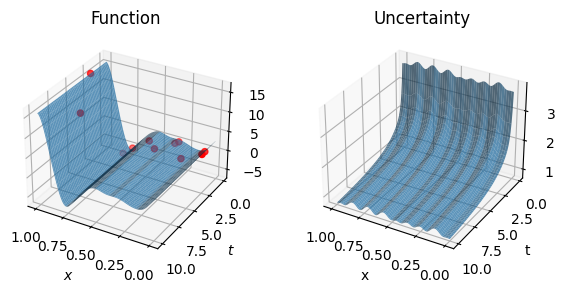

(a, b) =  (1.527, 0.269)
----Noise model calculation----


100%|██████████| 10000/10000 [00:06<00:00, 1639.25it/s, init loss: 77.9321, avg. loss [9501-10000]: 9.0138]



Inferred GP parameters
k_length         [0.5313 0.4595]
k_scale          0.0979
noise            0.0451
a                1.5002
b                0.302
Next location (x, t) =  [0.71717172 2.37777778]


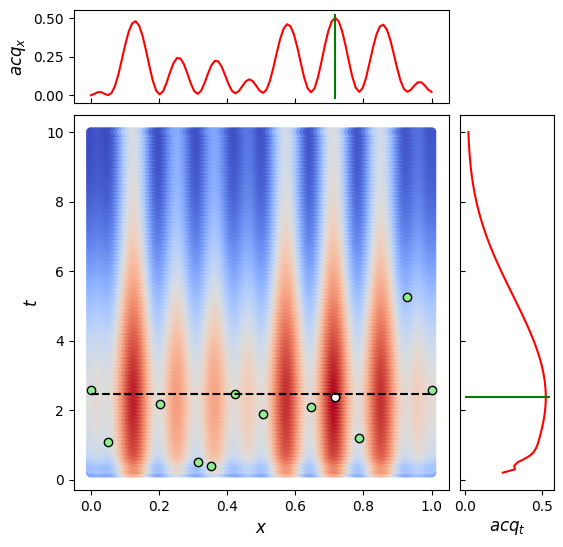

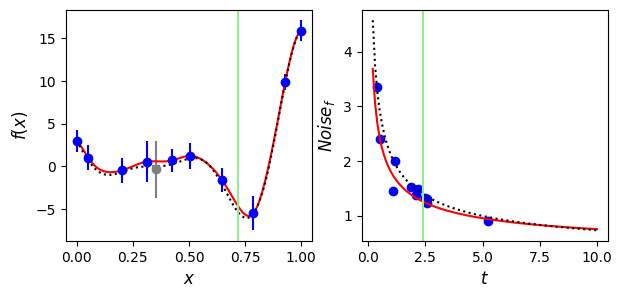


------------------ Iteration 9 -------------------



100%|██████████| 10000/10000 [00:07<00:00, 1358.46it/s, init loss: 115.5612, avg. loss [9501-10000]: 98.0948]



Inferred GP parameters
k_length         [1.0298 0.1022]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2045.50it/s, init loss: 79.3412, avg. loss [9501-10000]: 8.4592]



Inferred GP parameters
k_length         [0.5373 0.5373]
k_scale          0.11410000000000001
noise            0.047400000000000005
a                1.5363
b                0.2559

------------------  Results -------------------



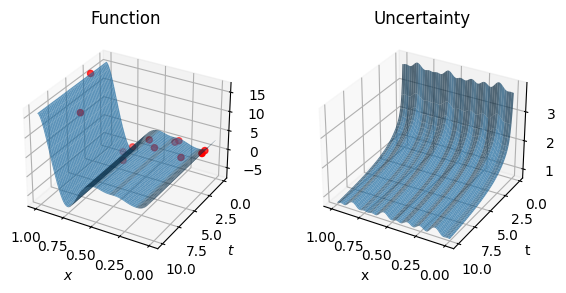

(a, b) =  (1.536, 0.256)
----Noise model calculation----


100%|██████████| 10000/10000 [00:06<00:00, 1659.47it/s, init loss: 78.8968, avg. loss [9501-10000]: 8.5258]



Inferred GP parameters
k_length         [0.536  0.4362]
k_scale          0.0949
noise            0.0376
a                1.5026000000000002
b                0.3004
Next location (x, t) =  [0.13131313 2.37777778]


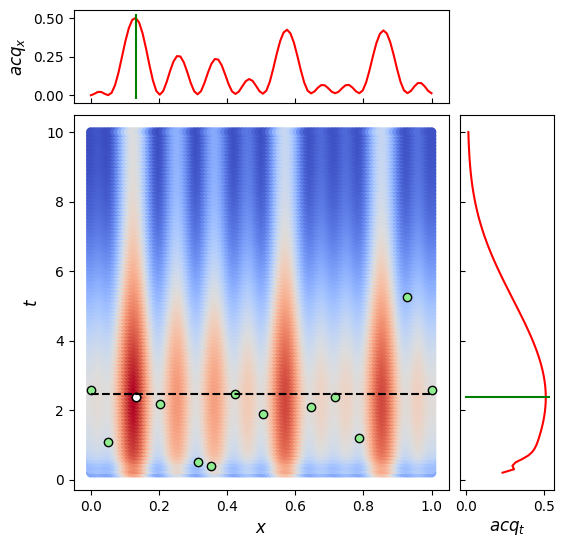

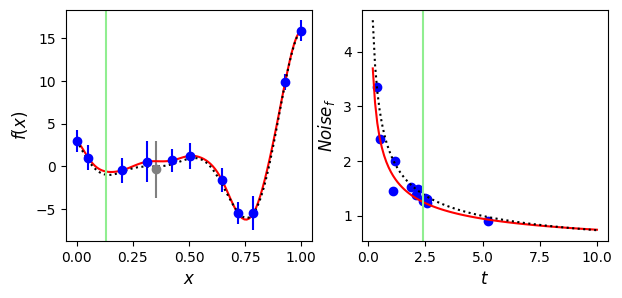


------------------ Iteration 10 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1502.90it/s, init loss: 117.9956, avg. loss [9501-10000]: 100.0785]



Inferred GP parameters
k_length         [1.0291 0.101 ]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:04<00:00, 2050.31it/s, init loss: 80.2895, avg. loss [9501-10000]: 7.9004]



Inferred GP parameters
k_length         [0.5412 0.5412]
k_scale          0.11220000000000001
noise            0.0414
a                1.5436
b                0.2487

------------------  Results -------------------



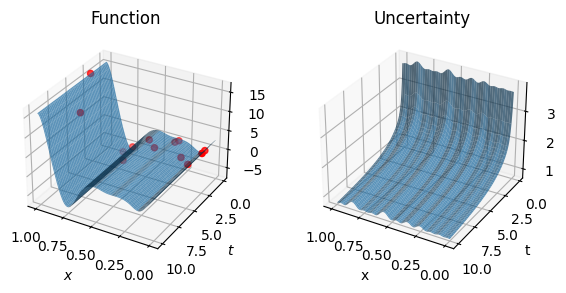

(a, b) =  (1.544, 0.249)
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1996.48it/s, init loss: 79.8399, avg. loss [9501-10000]: 7.9173]



Inferred GP parameters
k_length         [0.5147 0.3788]
k_scale          0.0907
noise            0.029500000000000002
a                1.4867000000000001
b                0.3236
Next location (x, t) =  [0.57575758 2.37777778]


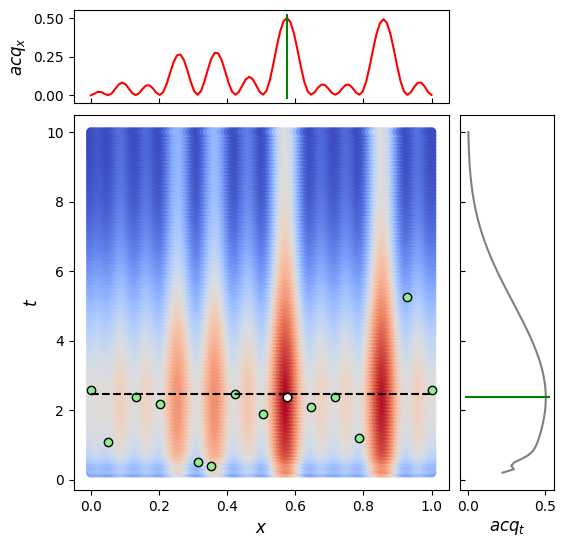

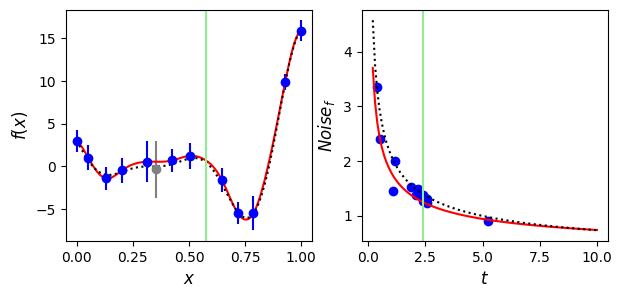


------------------ Iteration 11 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1520.12it/s, init loss: 120.4611, avg. loss [9501-10000]: 101.9244]



Inferred GP parameters
k_length         [1.0295 0.0996]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1946.92it/s, init loss: 81.1812, avg. loss [9501-10000]: 8.5500]



Inferred GP parameters
k_length         [0.4982 0.4982]
k_scale          0.1153
noise            0.0492
a                1.5264
b                0.276

------------------  Results -------------------



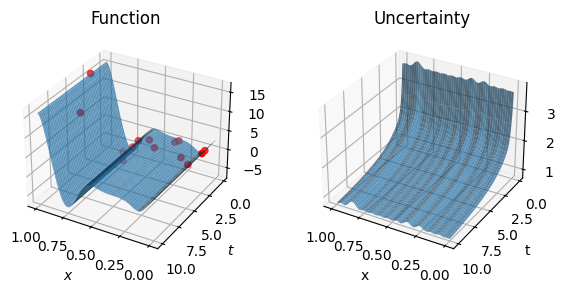

(a, b) =  (1.526, 0.276)
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1681.75it/s, init loss: 80.8000, avg. loss [9501-10000]: 8.5290]



Inferred GP parameters
k_length         [0.5127 0.4589]
k_scale          0.0981
noise            0.0397
a                1.4768000000000001
b                0.323
Noise GP already converged. Optimal duration: 2.38
Next location (x, t) =  [0.85858586 2.37777778]


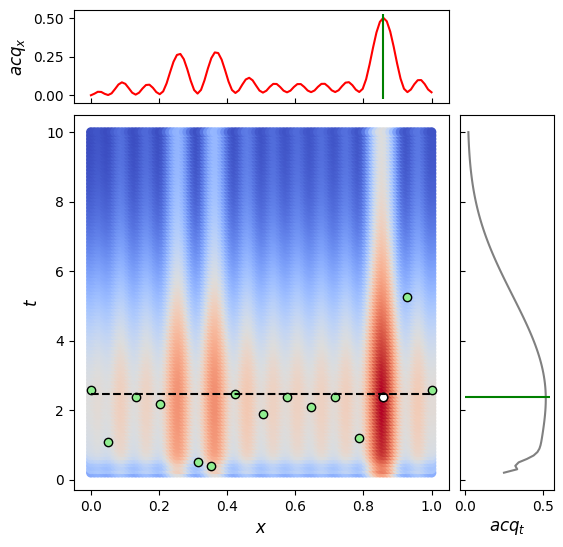

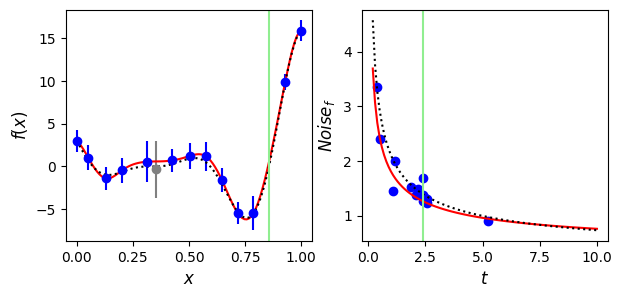


------------------ Iteration 12 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1505.04it/s, init loss: 126.5974, avg. loss [9501-10000]: 105.2173]



Inferred GP parameters
k_length         [1.0231 0.0926]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1855.06it/s, init loss: 82.0961, avg. loss [9501-10000]: 8.0395]



Inferred GP parameters
k_length         [0.4897 0.4897]
k_scale          0.114
noise            0.044500000000000005
a                1.5342
b                0.2679

------------------  Results -------------------



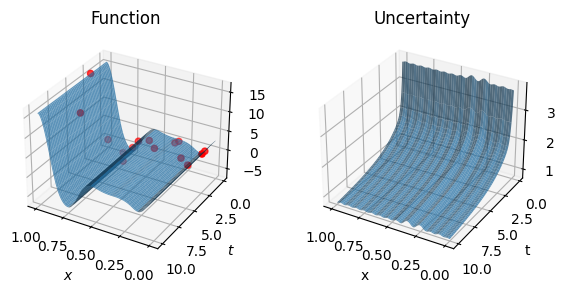

(a, b) =  (1.534, 0.268)
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1753.28it/s, init loss: 81.8298, avg. loss [9501-10000]: 7.9810]



Inferred GP parameters
k_length         [0.5308 0.4573]
k_scale          0.09860000000000001
noise            0.035300000000000005
a                1.4868000000000001
b                0.3158
Noise GP already converged. Optimal duration: 2.38
Next location (x, t) =  [0.36363636 2.37777778]


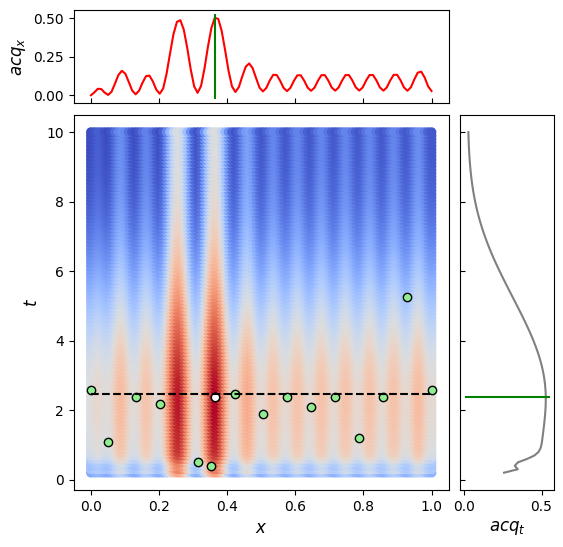

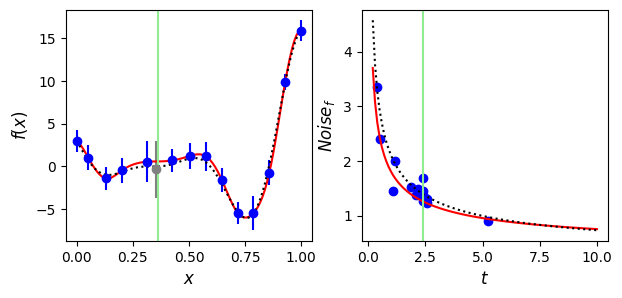


------------------ Iteration 13 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1478.30it/s, init loss: 127.8591, avg. loss [9501-10000]: 106.5353]



Inferred GP parameters
k_length         [1.0234 0.0927]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1803.48it/s, init loss: 82.9934, avg. loss [9501-10000]: 7.5942]



Inferred GP parameters
k_length         [0.4735 0.4735]
k_scale          0.1135
noise            0.0413
a                1.5394
b                0.26280000000000003

------------------  Results -------------------



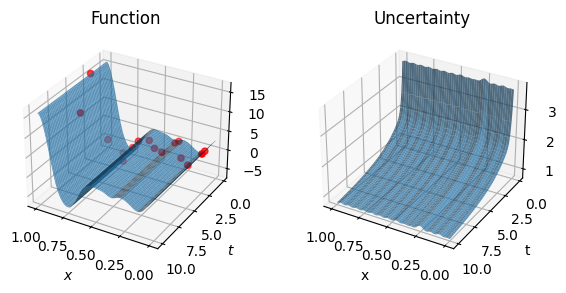

(a, b) =  (1.539, 0.263)
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1803.19it/s, init loss: 82.7509, avg. loss [9501-10000]: 7.4103]



Inferred GP parameters
k_length         [0.5218 0.4404]
k_scale          0.09910000000000001
noise            0.031400000000000004
a                1.4828000000000001
b                0.3201
Noise GP already converged. Optimal duration: 2.38
Next location (x, t) =  [0.25252525 2.37777778]


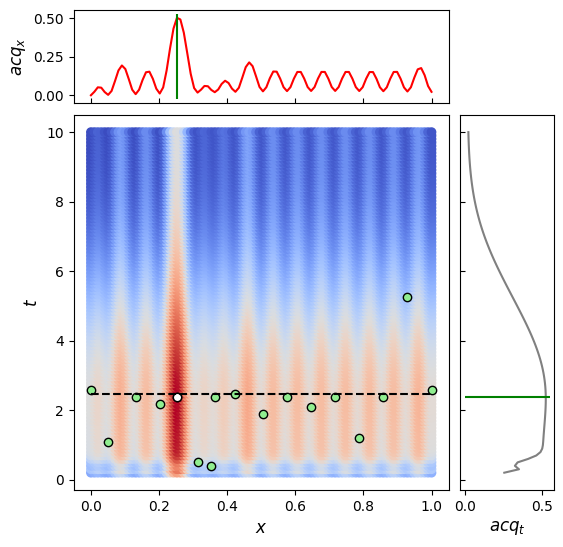

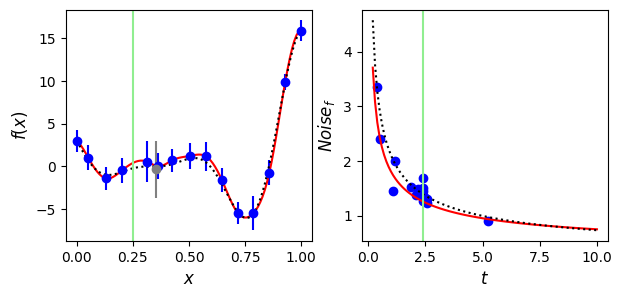


------------------ Iteration 14 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1569.43it/s, init loss: 129.2125, avg. loss [9501-10000]: 107.9926]



Inferred GP parameters
k_length         [1.0233 0.0927]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1835.06it/s, init loss: 83.8814, avg. loss [9501-10000]: 7.2225]



Inferred GP parameters
k_length         [0.4548 0.4548]
k_scale          0.1135
noise            0.0393
a                1.5414
b                0.2609

------------------  Results -------------------



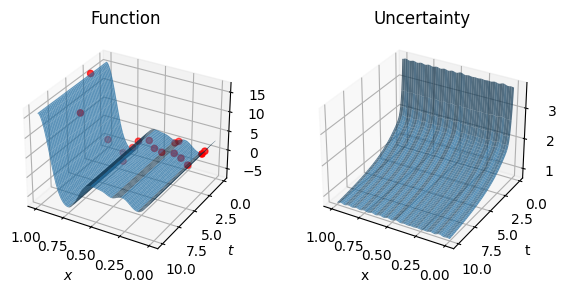

(a, b) =  (1.541, 0.261)
----Noise model calculation----


100%|██████████| 10000/10000 [00:05<00:00, 1776.30it/s, init loss: 83.6601, avg. loss [9501-10000]: 6.9660]



Inferred GP parameters
k_length         [0.5124 0.4107]
k_scale          0.09920000000000001
noise            0.0292
a                1.4723000000000002
b                0.3346
Noise GP already converged. Optimal duration: 2.38
Next location (x, t) =  [0.46464646 2.37777778]


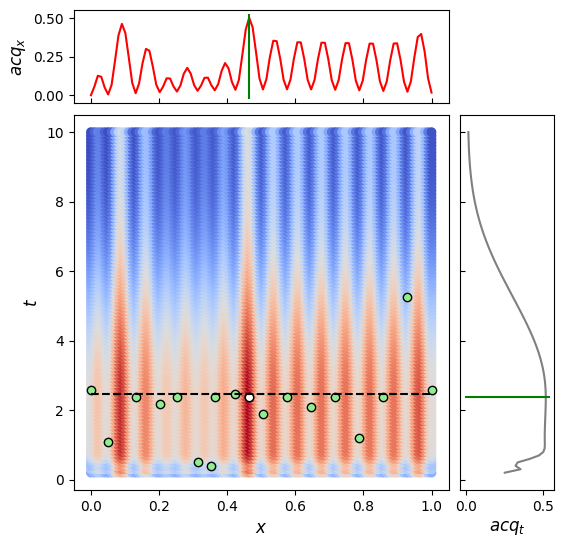

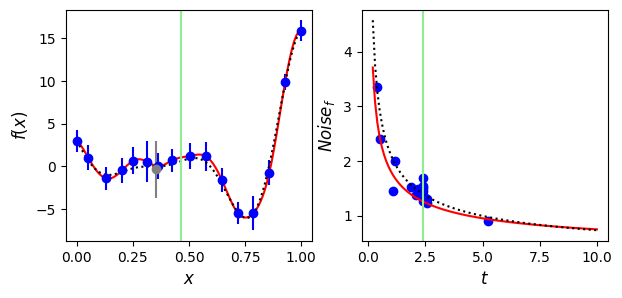

In [15]:
#noise models ground truth
a, b = 2, 0.1

#Experiment params
num_measurements = 30         # Number of measurements per x
num_measurements_conv = 3     # Number of measurements per x after convergence
num_iteration = 15            # Number of exploration steps
num_seeds = 3                 # Number of seed points
time_lim_seeds = 10           # time limit for the seed measurements

#converge params
conv_tail = 3
var_thresh = 5e-4

#wrapper for reward function
def rew_func(t, n):
  return reward2(t, n)[1]

#thresh_dist
x_dist_thresh = 0.1
noise_ratio_thresh = 2

#dictionary to save progress
res_dict = {}

#to save figs for videos
fig_1 = []
fig_2 = []

# Exploration field
x_all = np.linspace(0, 1, 100)
t_all = np.linspace(0.2, 10, 100)  # Start from 0.2 to avoid division by zero
X, T = np.meshgrid(x_all, t_all)

arg_opt_t = np.argmax(rew_func(t_all, variable_noise(t_all, a, b)))#np.argmax(target_smooth1(t_all, a, b, d, e))
opt_t = t_all[arg_opt_t]
print(f'Optimal measurement duration for a = {a} and b = {b}: {round(opt_t,2)}')

coordinates = np.array([X.flatten(), T.flatten()]).T

#-----------------------------------------------------------------------------

#Ground truth
Y     = forester_function2D(X, T)
Noise = variable_noise2D(X, T, a, b)
print('\n------------------  Ground truth -------------------\n')
fig = plot_3d(Y, Noise)
plt.show()

#Seed measurements
c = np.random.choice(coordinates[coordinates[:,1]<time_lim_seeds].shape[0],
                     size=num_seeds, replace=True)
meas_c = coordinates[coordinates[:,1]<time_lim_seeds][c] #seed coordinates

x = meas_c[:,0]
t = meas_c[:,1]
y_measurements = np.array([forrester_function(x[i]) +
                           np.random.normal(0, variable_noise(t[i], a, b),
                                            num_measurements) for i in range(len(x))]) #2d array (n_seeds, n_measurements)

# Calculate mean and variance for Y measurements at each X
y = np.mean(y_measurements, axis=1)
y_noise = np.std(y_measurements, axis=1, ddof=1)

ind_to_remove = np.array([])

res_dict['iter_-1']={'coord':meas_c,
                     'y': y,
                     'y_noise': y_noise,
                     'init_params': {'a0_a1': (b, a),
                                     't_opt': opt_t,
                                     'x_all': x_all,
                                     't_all': t_all,
                                     'coord_all': coordinates,
                                     'num_meas': num_measurements,
                                     'num_seed': num_seeds,
                                     'num_iter': num_iteration,
                                     'x_dist_thresh': x_dist_thresh,
                                     'noise_ratio_thresh': noise_ratio_thresh,
                                     'y_gt': forrester_function(x_all),
                                     },
                     }

for iter in range(num_iteration):
  print(f'\n------------------ Iteration {iter} -------------------\n')
  #remove ind
  dists = abs(x - x[-1])
  new_inds = np.where((dists < x_dist_thresh) & (y_noise > noise_ratio_thresh*y_noise[-1]))[0]
  ind_to_remove = np.unique(np.append(ind_to_remove, new_inds)).astype(int)


  #model initialization
  model = viMeasuredNoiseGP(input_dim=2,
                            kernel=MaternKernel_1dim, #custom kernel
                            guide='normal',
                            mean_fn_noise = mean_func_noise_linearized,
                            mean_fn_prior_noise = prior_noise,
                            )


  key1, key2 = gpax.utils.get_keys(1)

  meas_c_filt = np.delete(meas_c, ind_to_remove, axis=0)
  y_filt = np.delete(y, ind_to_remove, axis=0)
  y_noise_filt = np.delete(y_noise, ind_to_remove, axis=0)

  model.fit(key1, meas_c_filt, y_filt, y_noise_filt, num_steps=10000)
  y_pred, y_var = model.predict(key2,
                                coordinates,
                                noise_prediction_kernel = RBF_2nd_dim,
                                noise_prediction_method = 'gpreg',
                                noiseless=True)

  print('\n------------------  Results -------------------\n')
  fig = plot_3d(y_pred, y_var, points=np.array([x,t,y]))
  plt.show()


  a_ = float(model.noise_kernel_params['a'])
  b_ = float(model.noise_kernel_params['b'])
  print('(a, b) = ', (round(a_,3), round(b_,3)))

  acq = join_acq(base_acq = 'UE',
               noise_function = variable_noise,
               noise_reward_function = rew_func,
               rng_key = key1,
               model = model,
               X = coordinates,
               recent_points=meas_c,
               penalty='inverse_distance',)


  next_ind = np.argmax(acq)
  next_c = coordinates.copy()[next_ind]
  if np.std(t[-conv_tail:]) < var_thresh:
    next_c[-1] = t[-1]
    print(f'Noise GP already converged. Optimal duration: {round(next_c[-1],2)}')

  print('Next location (x, t) = ', next_c)

  res_dict[f'iter_{iter}'] = {'coord':meas_c,
                           'y': y,
                           'y_noise': y_noise,
                           'a0_a1': (b_,a_),
                           'ind_to_remove': ind_to_remove,
                           'y_pred': y_pred,
                           'y_var': y_var,
                           'acq': acq,
                           'next_ind': next_ind
                           }

  meas_c = np.vstack([meas_c, next_c])
  x = np.append(x, next_c[0])
  t = np.append(t, next_c[1])

  if np.std(t[-conv_tail:]) > var_thresh:
    res_dict[f'iter_{iter}']['converge'] = 0
    y_next = forrester_function(x[-1]) + np.random.normal(0, variable_noise(t[-1], a, b), num_measurements)
    y = np.append(y, np.mean(y_next))
    y_noise = np.append(y_noise, np.std(y_next, ddof=1))
  else:
    res_dict[f'iter_{iter}']['converge'] = 1
    y_next = np.array([forrester_function(x[-1]) + np.random.normal(0, variable_noise(t[-1], a, b), num_measurements_conv)])
    y = np.append(y, np.mean(y_next))
    y_noise = np.append(y_noise, np.mean(y_noise[-conv_tail:]))


  # ---------figures--------
  fig = plt.figure(figsize=(6, 6))
  gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)

  ax = fig.add_subplot(gs[1, 0])
  ax_x = fig.add_subplot(gs[0, 0], sharex=ax)
  ax_y = fig.add_subplot(gs[1, 1], sharey=ax)

  ax.scatter(coordinates[:,0], coordinates[:,1], c=acq, cmap='coolwarm')
  ax.scatter(meas_c[:,0], meas_c[:,1], color='lightgreen', edgecolors='black')
  ax.scatter(next_c[0], next_c[1], color='white', edgecolors='black')
  ax.hlines(opt_t, 0, 1, linestyle='dashed', color='black')
  ax.set_ylabel('$t$', fontsize=12)
  ax.set_xlabel('$x$', fontsize=12)

  if np.std(t[-conv_tail:]) > var_thresh:
    col_y = 'red'
  else:
    col_y = 'gray'
  ax_y.plot(acq[coordinates[:,0]==x_all[-1]], coordinates[coordinates[:,0]==x_all[-1]][:,1], c=col_y)
  xlims = ax_y.get_xlim()
  ax_y.hlines(next_c[-1], xlims[0], xlims[1], color='green')

  ax_x.plot(coordinates[coordinates[:,1]==t_all[-1]][:,0], acq[coordinates[:,1]==t_all[-1]], c='red')
  ylims = ax_x.get_ylim()
  ax_x.vlines(next_c[0], ylims[0], ylims[1], color='green')

  ax_x.set_ylabel('$acq_x$', fontsize=12)
  ax_y.set_xlabel('$acq_t$', fontsize=12)

  ax_x.tick_params(axis="x", labelbottom=False, direction='in')
  ax_y.tick_params(axis="y", labelleft=False, direction='in')
  plt.show()

  fig_1.append(fig)

  fig, ax = plt.subplots(1, 2, figsize=(7,3))

  ax[0].errorbar(meas_c_filt[:,0],y_filt, y_noise_filt, fmt='o', color='b')
  if len(ind_to_remove) > 0:
    ax[0].errorbar(meas_c[ind_to_remove][:,0], y[ind_to_remove], y_noise[ind_to_remove], fmt='o', color='gray')
  ax[0].plot(x_all, y_pred[coordinates[:,1]==t[-2]], '-', color='r')
  ax[0].plot(x_all, forrester_function(x_all), ':', color='black')
  ylim = ax[0].get_ylim()
  ax[0].vlines(meas_c[-1,0], ylim[0], ylim[1], color='lightgreen')
  ax[0].set_ylim(*ylim)
  ax[0].set_xlabel('$x$', fontsize=12)
  ax[0].set_ylabel('$f(x)$', fontsize=12)

  ax[1].plot(meas_c[:-1,1],y_noise[:-1], 'o', color='b')
  ax[1].plot(t_all, variable_noise(t_all, a_, b_), color='r')
  ax[1].plot(t_all, variable_noise(t_all, a, b), ':',color='black')
  ylim = ax[1].get_ylim()
  ax[1].vlines(meas_c[-1,1],ylim[0], ylim[1], color='lightgreen')
  ax[1].set_ylim(*ylim)
  ax[1].set_xlabel('$t$', fontsize=12)
  ax[1].set_ylabel('$Noise_f$', fontsize=12)

  plt.show()

  fig_2.append(fig)

save_dict_to_hdf5('res.h5', res_dict)





In [16]:
make_video('parameter_space.mp4', fig_1, fps=1);

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [17]:
Video('parameter_space.mp4', embed=True)

In [18]:
make_video('function_noise.mp4', fig_2, fps=1);

In [19]:
Video('function_noise.mp4', embed=True)

# Forensic

In [20]:
data = load_hdf5_to_dict('res.h5')

In [21]:
iter = np.array([])
a1_ar = np.array([])
a0_ar = np.array([])
conv = np.array([])
y_pred = []
t_iter = []
y_prof = []
acq_list = []
meas_coord = []
y_meas_list = []
y_noise_list = []

def dict_key(d):
  return int(d.split('_')[1])

key_list = sorted(list(data.keys()), key = dict_key)

for k in key_list:
  step = int(k.split('_')[-1])
  if step != -1:
    iter = np.append(iter, step)
    a1_ar = np.append(a1_ar, data[k]['a0_a1'][1])
    a0_ar = np.append(a0_ar, data[k]['a0_a1'][0])
    conv = np.append(conv, bool(data[k]['converge']))
    y_pred.append(data[k]['y_pred'])
    meas_coord.append(data[k]['coord'])
    t_iter.append(data[k]['coord'][-1,1])
    y_prof.append(data[k]['y_pred'][coord_all[:,1]==t_iter[-1]])
    acq_list.append(data[k]['acq'])

    y_meas_list.append(data[k]['y'])
    y_noise_list.append(data[k]['y_noise'])
  else:
    a1_gt = data[k]['init_params']['a0_a1'][1]
    a0_gt = data[k]['init_params']['a0_a1'][0]
    exp_time_opt = data[k]['init_params']['t_opt']
    y_gt = data[k]['init_params']['y_gt']
    coord_all = data[k]['init_params']['coord_all']
y_pred = np.array(y_pred)
y_prof = np.array(y_prof)

rmse_y = np.sqrt(np.mean((y_prof-y_gt)**2, axis=1))

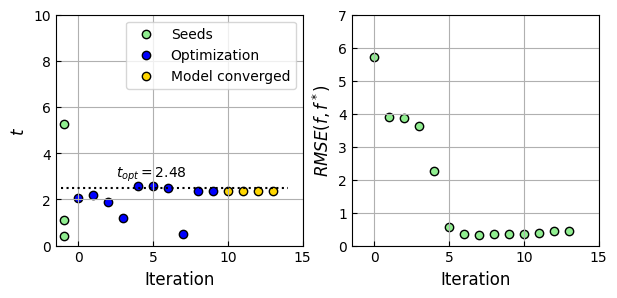

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

seeds = data[key_list[-1]]['coord'][:3, -1]
exp_time = data[key_list[-1]]['coord'][3:, -1]

ax[0].scatter(-np.ones(len(seeds)), seeds, color='lightgreen', ec='black', label='Seeds')
ax[0].scatter(iter[:-1][conv[:-1]==0], exp_time[conv[:-1]==0], c='blue', ec='black', label='Optimization')
ax[0].scatter(iter[:-1][conv[:-1]==1], exp_time[conv[:-1]==1], c='gold', ec='black', label='Model converged')
ax[0].hlines(exp_time_opt, -1.2, iter[-1], linestyle = ':', color = 'black')
ax[0].text(2.5, exp_time_opt+.5, s='$t_{opt}=$'+ '{}'.format(round(float(exp_time_opt), 2)))

ax[0].set_ylim(0, 10)
ax[0].set_ylabel('$t$', fontsize=12)
ax[0].legend()


ax[1].scatter(iter[:-1], rmse_y[:-1], color='lightgreen', ec='black', label='Seeds')
ax[1].set_ylabel('$RMSE(f,f^*)$', fontsize=12)
ax[1].set_ylim(0,7)


for _ in ax:
  _.tick_params('both', direction='in')
  _.grid()
  _.set_xlim(-1.5,  iter[-1]+1)
  _.set_xlabel('Iteration', fontsize=12)

fig.savefig('model_res0.jpg', dpi=300, bbox_inches='tight')

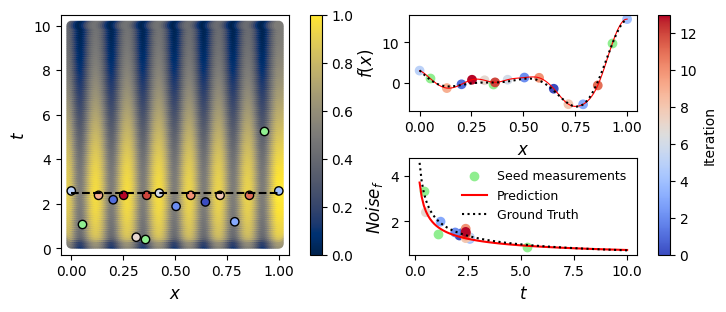

In [23]:
# Create a single figure with GridSpec
fig = plt.figure(figsize=(7, 3))
gs = fig.add_gridspec(3, 5, width_ratios=(1,0.05,0.2, 1,0.05), height_ratios=(1,0.2,1),
                      left=0.03, right=0.9, bottom=0.1, top=0.9, wspace=0.2)



# First subplot set (similar to the first figure in your code)
ax_main = fig.add_subplot(gs[:,0])
ax_f = fig.add_subplot(gs[0,  3])
ax_n = fig.add_subplot(gs[2, 3])
ax_bar = fig.add_subplot(gs[:, 4])
ax_bar1 = fig.add_subplot(gs[:, 1])


scatter1 = ax_main.scatter(coord_all[:,0], coord_all[:,1], c=acq_list[4], cmap='cividis')
ax_main.scatter(meas_coord[-1][:3,0], meas_coord[-1][:3,1], edgecolors='black', c='lightgreen')
scatter2 = ax_main.scatter(meas_coord[-1][3:,0], meas_coord[-1][3:,1], c=iter[:-1], edgecolors='black', cmap='coolwarm')
ax_main.hlines(exp_time_opt, 0, 1, linestyle='dashed', color='black')
ax_main.set_ylabel('$t$', fontsize=12)
ax_main.set_xlabel('$x$', fontsize=12)

cbar1 = plt.colorbar(scatter2, cax=ax_bar, orientation='vertical')
cbar1.set_label('Iteration', fontsize=10)

cbar2 = plt.colorbar(scatter1, orientation='vertical', cax = ax_bar1, fraction=0.046, pad=0.04)


ax_f.plot(coord_all[coord_all[:,1]==exp_time[-1]][:,0], y_pred[-1][coord_all[:,1]==exp_time[-1]],
          c='red', lw=0.8, label='Prediction')
ax_f.scatter(meas_coord[-1][:3,0], y_meas_list[-1][:3], c='lightgreen', label='Seed measurements')
ax_f.scatter(meas_coord[-1][3:,0], y_meas_list[-1][3:], c=iter[:-1], cmap='coolwarm')
ax_f.plot(np.unique(coord_all[:,0]), y_gt, ':', c='black', label='Ground Truth')
ax_f.set_ylabel('$f(x)$', fontsize=12)
ax_f.set_xlabel('$x$', fontsize=12)


t_all = coord_all[coord_all[:,0]==0][:,1]

ax_n.scatter(meas_coord[-1][:3,1], y_noise_list[-1][:3], c='lightgreen', label='Seed measurements')
ax_n.scatter(meas_coord[-1][3:,1], y_noise_list[-1][3:], c=iter[:-1],  cmap='coolwarm')
ax_n.plot(t_all, variable_noise(t_all, a1_ar[-1], a0_ar[-1]), color='r', label='Prediction')
ax_n.plot(t_all, variable_noise(t_all, a1_gt, a0_gt), ':',color='black', label='Ground Truth')
ax_n.legend(frameon=False, fontsize=9)
ax_n.set_xlabel('$t$', fontsize=12)
ax_n.set_ylabel('$Noise_f$', fontsize=12)

fig.savefig('model_res1.jpg', dpi=300, bbox_inches='tight')

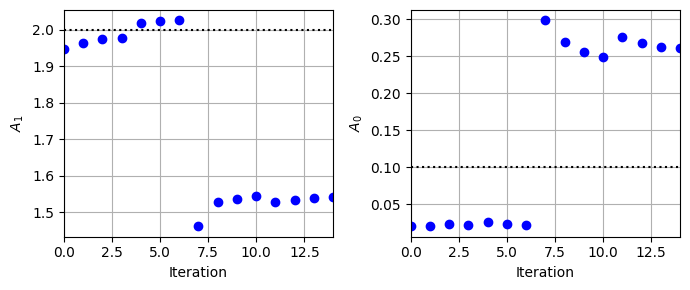

In [24]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(iter, a1_ar, 'o', color='blue')
ax[0].hlines(a1_gt, iter[0], iter[-1], linestyle = ':', color = 'black')
ax[0].set_ylabel('$A_1$')

ax[1].plot(iter, a0_ar, 'o', color='blue')
ax[1].hlines(a0_gt, iter[0], iter[-1], linestyle = ':', color = 'black')
ax[1].set_ylabel('$A_0$')

for _ in ax:
  _.grid()
  _.set_xlabel('Iteration')
  _.set_xlim(iter[0], iter[-1])

plt.tight_layout()